In [1]:
from transformers import BertTokenizer, BertModel
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
!pip install openai
import openai
from openai import OpenAI
client = OpenAI(base_url='https://xiaoai.plus/v1',
                api_key='sk-oKBpYxrlyq6ZC2SsIzR8bOj4nbX7lyOGpRyxhBk8UPKVJ8Eu')

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.3/454.3 kB 8.7 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.0/345.0 kB 23.7 MB/s eta 0:00:00


In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased') # bert-base-uncased OR bert-base-multilingual-cased
model = BertModel.from_pretrained("bert-base-multilingual-cased")
text = "The color is cyan."
encoded_input = tokenizer(text, return_tensors='pt')
print(encoded_input)
show_encode_input = tokenizer.decode(encoded_input['input_ids'][0])
print('words divided:',show_encode_input)
output = model(**encoded_input)
print('output shape',output[0].shape)

# OR us OPENAI text-embedding-3-small embedding
def get_openai_embedding(text, model="text-embedding-3-large"):# text-embedding-3-small,text-similarity-davinci-001
    text = text.replace("\n", " ")
    embedding_list = client.embeddings.create(input = [text], model=model, dimensions=768).data[0].embedding
    return np.array(embedding_list)
print('output1 shape',get_openai_embedding(text).shape)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

{'input_ids': tensor([[  101, 10117, 14136, 10124,   171, 15976,   119,   102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}
words divided: [CLS] The color is cyan. [SEP]
output shape torch.Size([1, 8, 768])
output1 shape (768,)


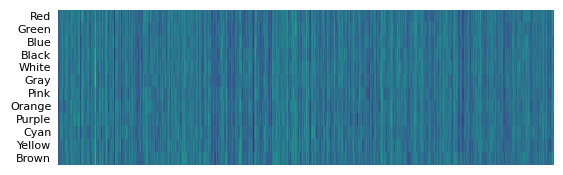

In [3]:
all_colors = ['Red',	
'Green'	,
'Blue',	
'Black'	,
'White'	,
'Gray'	,
'Pink'	,
'Orange',	
'Purple',	
'Cyan'	,
'Yellow',	
'Brown']
color_and_embeddings = {}
color_num = len(all_colors)
all_ax = []
bar_height = 20

for i,color_names in enumerate(all_colors):
    target_text = 'The color is '+color_names+'.'
    # # choose 1
    # encoded_input = tokenizer(target_text, return_tensors='pt')
    # output = model(**encoded_input)
    # color_and_embeddings[color_names] = torch.mean(output[0][0,:,:],dim=0).cpu().detach().numpy()   # use mean pooled embedding of the sentence
    
    # OR 2
    color_and_embeddings[color_names] = get_openai_embedding(target_text)
   
    # show_encode_input = tokenizer.decode(encoded_input['input_ids'][0,4]) 
    # print('words divided:',show_encode_input)
    embeddings_to_plot = np.array([color_and_embeddings[color_names] for i in range(bar_height)])
    # print(embeddings_to_plot.shape)
    all_ax.append(embeddings_to_plot)

out_df = pd.DataFrame.from_dict(color_and_embeddings,orient='index')
out_df.reset_index().rename(columns={'index':'color'})
out_df.to_csv('basic_color_embeddings.csv')

fig, ax = plt.subplots()
ax.imshow(np.vstack(all_ax))
                     
for i, label in enumerate(all_colors):
    ax.text(-10, i * bar_height + bar_height / 2, label, va='center', ha='right', fontsize=8, color='black')
# Display the bar using Matplotlib
# plt.tight_layout()
plt.axis('off')  # Turn off axes
plt.show()

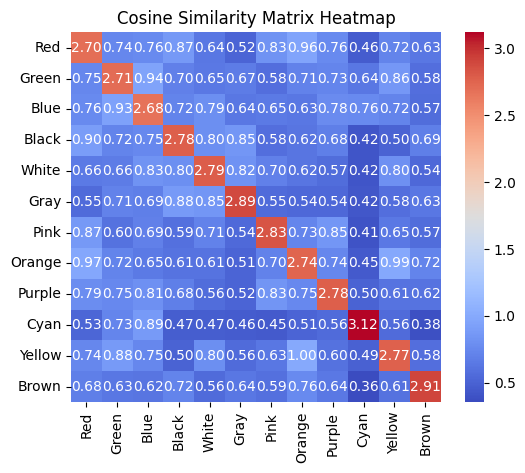

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

X_data = np.array(list(color_and_embeddings.values()))
cov_matrix = cosine_similarity(X_data)

# infoNCE loss 形式处理
dominator_by_row = np.sum(np.exp(cov_matrix/0.5),axis=1).reshape(-1,1)
dominator = np.tile(dominator_by_row,reps=(1,len(dominator_by_row)))
numerator = np.exp(cov_matrix/0.2)
cov_matrix_infonce = numerator/dominator
cov_df_infonce = pd.DataFrame(cov_matrix_infonce,
                              columns=list(color_and_embeddings.keys()),
                             index=list(color_and_embeddings.keys()))

# cov_df_infonce = pd.DataFrame(cov_matrix,
#                               columns=list(color_and_embeddings.keys()),
#                              index=list(color_and_embeddings.keys()))
# 展示协方差矩阵
sns.heatmap(cov_df_infonce, annot=True, cmap='coolwarm', fmt='.2f', square=True)
# 显示图形
plt.title('Cosine Similarity Matrix Heatmap')
plt.show()

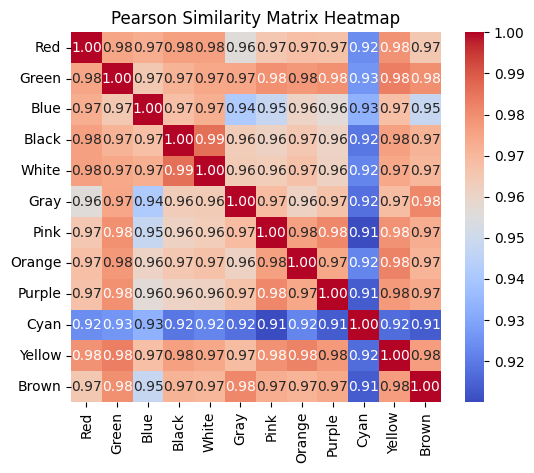

In [52]:
pearson_df = out_df.T
pearson_cov_mat = pearson_df.corr(method='pearson')
# 展示计算的协方差矩阵
sns.heatmap(pearson_cov_mat, annot=True, cmap='coolwarm', fmt='.2f', square=True)
# 显示图形
plt.title('Pearson Similarity Matrix Heatmap')
plt.show()

MDS visualization

In [ ]:
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances,cosine_distances
from sklearn.manifold import MDS
X = np.array(list(color_and_embeddings.values()))
print(X.shape)
dist_cosine = cosine_distances(X) # 样本两两之间的距离矩阵，nxn
mds = MDS(n_components=3,dissimilarity='precomputed', random_state=0)
# Get the embeddings
X_transform_L2 = mds.fit_transform(dist_cosine)
print('MDS 降维后的嵌入点:\n',X_transform_L2)
print('stress:',mds.stress_)

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
plt.scatter(X_transform_L2[:,0], X_transform_L2[:,1], zs=X_transform_L2[:,2],s=64)
plt.title('MDS Points(3D)')
plt.show()

train model

In [1]:
!git clone https://github.com/auto-Dog/name_estimator.git

fatal: destination path 'name_estimator' already exists and is not an empty directory.


In [1]:
%cd name_estimator
!git pull

/kaggle/working/name_estimator
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 8 (delta 6), reused 8 (delta 6), pack-reused 0 (from 0)
Unpacking objects: 100% (8/8), 813 bytes | 271.00 KiB/s, done.
From https://github.com/auto-Dog/name_estimator
   7c4900b..c649370  main       -> origin/main
Updating 7c4900b..c649370
Fast-forward
 dataloaders/CVDDS.py | 6 +++---
 network/colorLoss.py | 4 ++--
 network/model.py     | 2 +-
 train_deu.sh         | 5 +++--
 4 files changed, 9 insertions(+), 8 deletions(-)


In [ ]:
!python train.py --prefix vit_cn4a --size 512 --patch 16 --batchsize 32 --dataset /kaggle/input/imagenet1k-subset-100k-train-and-10k-val

Namespace(lr=0.0001, patch=16, size=512, t=0.5, save_interval=5, test_fold=None, batchsize=32, test=False, epoch=50, dataset='/kaggle/input/imagenet1k-subset-100k-train-and-10k-val', cvd='deutan', x_bins=256.0, y_bins=256.0, prefix='vit_cn4a')
Dataset Information: Training Samples:48372, Validating Samples:4500
===========Epoch:0==============
  0%|                              | 0/1512 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/parallel_apply.py:79: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.device(device), torch.cuda.stream(stream), autocast(enabled=autocast_enabled):
100%|###################| 1512/1512 [50:25<00:00,  2.00s